In [37]:
import os
import sys
import pandas as pd
from main import ANF
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns

sns.set(style="darkgrid")

NUMBER_OF_BINS = 11


In [32]:
# Compute hop exponent for all results
def get_hop_exponent_per_country(results):
  hop_exp = {}
  for c in results.keys():
    hop_exp[c] = get_exponent(results[c]['neighbourhoods'])
  return hop_exp

def get_exponent(neighbourhoods):
  x = np.arange(0, len(neighbourhoods))

  (a, b, c), pcov = curve_fit(func, x, neighbourhoods)
  return b

# Example function to fit to
def func(x, a, b, c):
    return a * x**b + c

In [33]:
countries = ['austria', 'netherlands', 'hungary', 'liechtenstein', 'malta']

folder_name = f'data/intersections'

for country in countries:
  for step in range(0, NUMBER_OF_BINS):
    filename = f'{folder_name}/{country}-highways-{100 - (step * 5)}.csv'
    edges = pd.read_csv(filename, delimiter=' ', header=None)

    data = ANF(filename, show_IN=True)
    IN = data['individual_neighbourhoods']

    df = pd.DataFrame.from_dict(IN).transpose()
    df = df[[1, 2, 3, 4]]

    # calculate hop exponent
    exp = []
    for i in range(len(df)):
      exp.append(get_exponent(df.iloc[i]))
    df['hop_exponent'] = exp

    # sort hop exponent and remove x largest
    hop = df.sort_values('hop_exponent', ascending=False)
    n_to_remove = int(len(hop) * 0.05)
    nodes_to_remove = np.array(hop[:n_to_remove].index.values, dtype=int)

    # remove nodes
    new_edges = edges.where(edges[0].isin(nodes_to_remove) == False).where(edges[1].isin(nodes_to_remove) == False).dropna()
    new_edges = new_edges.astype(int)

    # write new edges to file
    new_filename = f'{folder_name}/{country}-highways-{100 - ((step+1) * 5)}.csv'
    new_edges.to_csv(new_filename, sep=' ', header=False, index=False)

/tmp/ipykernel_18273/1797821753.py:16: RuntimeWarning: divide by zero encountered in power
  return a * x**b + c
/home/matthias/.local/share/virtualenvs/SNACS-road-intersections-gG9xqkeW/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [38]:
H = {}

for country in countries:
  H[country] = []
  for step in range(0, NUMBER_OF_BINS):
    filename = f'{folder_name}/{country}-highways-{100 - (step * 5)}.csv'
    data = ANF(filename)
    H[country] = [*(H[country]), get_exponent(data['neighbourhoods'])]

H

/tmp/ipykernel_18273/1797821753.py:16: RuntimeWarning: divide by zero encountered in power
  return a * x**b + c


{'austria': [1.2269332645390074,
  1.1533816234444902,
  1.0783351482624595,
  1.0112757849735872,
  0.9514494288618758,
  0.893901331623016,
  0.8364666273066261,
  0.7762792957855487,
  0.7201029225810534,
  0.6702211420108368,
  0.6239684327790223],
 'netherlands': [1.1647151502320854,
  1.090003620115483,
  1.0177531502259058,
  0.9614990746737577,
  0.907650339942326,
  0.8450405062383277,
  0.7990559181382157,
  0.7575000638253225,
  0.7079418341154906,
  0.6608702126405185,
  0.6180489079844459],
 'hungary': [1.1945236851534324,
  1.1244011132888025,
  1.0563687653142149,
  0.9946598511264386,
  0.9318574916504229,
  0.8759814669609545,
  0.8236593779804537,
  0.7732167793938607,
  0.711465472864594,
  0.6573344632659875,
  0.6055020330714521],
 'liechtenstein': [0.8204228383080175,
  0.8166097455951267,
  0.7414420361008235,
  0.7234735023201307,
  0.8253413598512451,
  0.7734771387944063,
  0.760138693806329,
  0.6974919850016933,
  0.8018580293380768,
  0.7563418123793291,
  

In [39]:
df = pd.DataFrame.from_dict(H)
df.columns = df.columns.str.title()
df.index = [f'{100 - (x * 5)}%' for x in range(0, NUMBER_OF_BINS)]
df

,Austria,Netherlands,Hungary,Liechtenstein,Malta
100%,1.226933,1.164715,1.194524,0.820423,1.022540
95%,1.153382,1.090004,1.124401,0.816610,1.028107
90%,1.078335,1.017753,1.056369,0.741442,0.989900
85%,1.011276,0.961499,0.994660,0.723474,0.898034
80%,0.951449,0.907650,0.931857,0.825341,0.889897
75%,0.893901,0.845041,0.875981,0.773477,0.773801
70%,0.836467,0.799056,0.823659,0.760139,0.715760
65%,0.776279,0.757500,0.773217,0.697492,0.671521
60%,0.720103,0.707942,0.711465,0.801858,0.660042
55%,0.670221,0.660870,0.657334,0.756342,0.608700


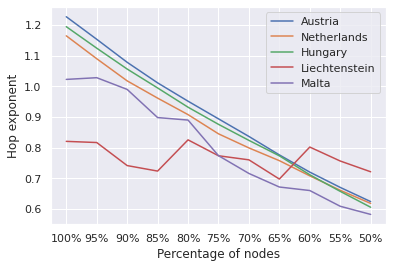

In [41]:
sns.lineplot(data=df, dashes=False)
plt.xlabel('Percentage of nodes')
plt.ylabel('Hop exponent')
plt.savefig(f'images/hop_exponent.pdf')